### 데이터 불러오기

In [1]:
import os
import numpy as np

In [2]:
from itertools import product

In [3]:
datadir = 'dataset'

In [4]:
data_to_load = ['X_train', 'y_train', 'X_valid', 'y_valid', 'X_test', 'y_test'];

In [5]:
for var_name in data_to_load:
    file_load_path = os.path.join(datadir, var_name)
    globals()[var_name] = np.load(file_load_path+'.npy')

### 텐서보드 셋업

In [6]:
from tensorflow import keras

In [7]:
def makedirs(path):
   try: 
        os.makedirs(path)
   except OSError: 
       if not os.path.isdir(path):
           raise

In [8]:
root_logdir = os.path.join(os.curdir,"result/tensorboard_logs")

In [9]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

### 모델 저장 및 불러오기 셋업

In [10]:
root_chkdir = os.path.join(os.curdir, "result/checkpoint_logs")

In [22]:
import json

In [23]:
def param_metadata(path, param):
    with open(path, 'w') as file:
        file.write(json.dumps(param))

In [11]:
def get_run_chkdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_chkdir, run_id)

### 모델 생성 및 학습(하이퍼파라미터 튜닝)

#### 고정시킬 하이퍼파라미터 (고정시키니까, 사실상 파라미터라 할 수 없음)

In [12]:
patience = 10
epochs = 10
batch_size = 256

#### 변화시킬 하이퍼파라미터

In [13]:
import json

In [14]:
param_distribs = {
    "n_hidden": [2],
    "n_neurons": [10],
    "loss": ["mae"],
    "activation": ["elu"],
    "optimizer": ["adam"],
    "dropout": [True, False],
    "batch_norm": [True, False]
}

In [15]:
def dict_product(dicts):
    return (dict(zip(dicts, x)) for x in product(*dicts.values()))

In [19]:
def build_model(param):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(3,)))
    for _ in range(param["n_hidden"]):
        model.add(keras.layers.Dense(param["n_neurons"], activation=param["activation"]))
        if(param["dropout"]):
            model.add(keras.layers.Dropout(rate=0.2))
        if(param["batch_norm"]):
            model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1))
    model.compile(loss=param["loss"], optimizer=param["optimizer"])
    return model

In [20]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience)

In [24]:
for param in dict_product(param_distribs):
    model = build_model(param)
    run_logdir = get_run_logdir()
    run_chkdir = get_run_chkdir()
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
    model_file_path = os.path.join(run_chkdir,'{epoch:02d}-{val_loss:.4f}.hdf5')
    checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=model_file_path, monitor='val_loss', verbose=1,
                                                    save_best_only=True)
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid),
         callbacks = [early_stopping_cb, tensorboard_cb, checkpoint_cb])
    param_path = os.path.join(run_chkdir, 'param.txt')
    param_metadata(param_path, param)

2022-03-25 16:17:07.250468: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 16:17:07.250488: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-25 16:17:07.705311: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-25 16:17:07.705527: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/10
   1/1854 [..............................] - ETA: 14:10 - loss: 1.3402

2022-03-25 16:17:08.283587: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 16:17:08.283610: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  26/1854 [..............................] - ETA: 39s - loss: 1.2829 

2022-03-25 16:17:08.605230: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-25 16:17:08.605857: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-25 16:17:08.640079: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 159 callback api events and 157 activity events. 
2022-03-25 16:17:08.644343: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-25 16:17:08.655893: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./result/tensorboard_logs/run_2022_03_25-16_17_07/train/plugins/profile/2022_03_25_16_17_08

2022-03-25 16:17:08.664814: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./result/tensorboard_logs/run_2022_03_25-16_17_07/train/plugins/profile/2022_03_25_16_17_08/18-sshinohs.notebook.dlpc.trace.json.gz
2022-03-25 16:17:08

1854/1854 [==============================] - 11s 6ms/step - loss: 0.4946 - val_loss: 0.3990

Epoch 00001: val_loss improved from inf to 0.39900, saving model to ./result/checkpoint_logs/run_2022_03_25-16_17_07/01-0.3990.hdf5
Epoch 2/10
1854/1854 [==============================] - 10s 5ms/step - loss: 0.4002 - val_loss: 0.3887

Epoch 00002: val_loss improved from 0.39900 to 0.38875, saving model to ./result/checkpoint_logs/run_2022_03_25-16_17_07/02-0.3887.hdf5
Epoch 3/10
1854/1854 [==============================] - 10s 5ms/step - loss: 0.3962 - val_loss: 0.3977

Epoch 00003: val_loss did not improve from 0.38875
Epoch 4/10
1854/1854 [==============================] - 10s 5ms/step - loss: 0.3946 - val_loss: 0.3954

Epoch 00004: val_loss did not improve from 0.38875
Epoch 5/10
1854/1854 [==============================] - 10s 6ms/step - loss: 0.3937 - val_loss: 0.3908

Epoch 00005: val_loss did not improve from 0.38875
Epoch 6/10
1854/1854 [==============================] - 10s 5ms/step -

2022-03-25 16:18:49.461531: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 16:18:49.461551: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-25 16:18:49.942871: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-25 16:18:49.943068: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/10
   1/1854 [..............................] - ETA: 8:09 - loss: 1.0738

2022-03-25 16:18:50.306174: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 16:18:50.306196: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  38/1854 [..............................] - ETA: 22s - loss: 0.9396

2022-03-25 16:18:50.583138: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-25 16:18:50.583766: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-25 16:18:50.619144: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 77 callback api events and 75 activity events. 
2022-03-25 16:18:50.622043: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-25 16:18:50.627326: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./result/tensorboard_logs/run_2022_03_25-16_18_49/train/plugins/profile/2022_03_25_16_18_50

2022-03-25 16:18:50.630210: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./result/tensorboard_logs/run_2022_03_25-16_18_49/train/plugins/profile/2022_03_25_16_18_50/18-sshinohs.notebook.dlpc.trace.json.gz
2022-03-25 16:18:50.6

1854/1854 [==============================] - 7s 4ms/step - loss: 0.4478 - val_loss: 0.4019

Epoch 00001: val_loss improved from inf to 0.40194, saving model to ./result/checkpoint_logs/run_2022_03_25-16_18_49/01-0.4019.hdf5
Epoch 2/10
1854/1854 [==============================] - 7s 4ms/step - loss: 0.4031 - val_loss: 0.3957

Epoch 00002: val_loss improved from 0.40194 to 0.39567, saving model to ./result/checkpoint_logs/run_2022_03_25-16_18_49/02-0.3957.hdf5
Epoch 3/10
1854/1854 [==============================] - 7s 4ms/step - loss: 0.3973 - val_loss: 0.3900

Epoch 00003: val_loss improved from 0.39567 to 0.38997, saving model to ./result/checkpoint_logs/run_2022_03_25-16_18_49/03-0.3900.hdf5
Epoch 4/10
1854/1854 [==============================] - 7s 4ms/step - loss: 0.3927 - val_loss: 0.3775

Epoch 00004: val_loss improved from 0.38997 to 0.37750, saving model to ./result/checkpoint_logs/run_2022_03_25-16_18_49/04-0.3775.hdf5
Epoch 5/10
1854/1854 [==============================] - 7s 

2022-03-25 16:19:56.508291: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 16:19:56.508316: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-25 16:19:57.075731: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-25 16:19:57.075944: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/10
   1/1854 [..............................] - ETA: 13:19 - loss: 1.1951

2022-03-25 16:19:57.592287: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 16:19:57.592310: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  27/1854 [..............................] - ETA: 31s - loss: 1.1072

2022-03-25 16:19:57.860089: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-25 16:19:57.860797: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-25 16:19:57.895070: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 145 callback api events and 143 activity events. 
2022-03-25 16:19:57.898932: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-25 16:19:57.905464: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./result/tensorboard_logs/run_2022_03_25-16_19_56/train/plugins/profile/2022_03_25_16_19_57

2022-03-25 16:19:57.909632: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./result/tensorboard_logs/run_2022_03_25-16_19_56/train/plugins/profile/2022_03_25_16_19_57/18-sshinohs.notebook.dlpc.trace.json.gz
2022-03-25 16:19:57

1854/1854 [==============================] - 11s 6ms/step - loss: 0.4254 - val_loss: 0.3813

Epoch 00001: val_loss improved from inf to 0.38126, saving model to ./result/checkpoint_logs/run_2022_03_25-16_19_56/01-0.3813.hdf5
Epoch 2/10
1854/1854 [==============================] - 10s 5ms/step - loss: 0.3859 - val_loss: 0.3559

Epoch 00002: val_loss improved from 0.38126 to 0.35587, saving model to ./result/checkpoint_logs/run_2022_03_25-16_19_56/02-0.3559.hdf5
Epoch 3/10
1854/1854 [==============================] - 10s 5ms/step - loss: 0.3832 - val_loss: 0.3549

Epoch 00003: val_loss improved from 0.35587 to 0.35491, saving model to ./result/checkpoint_logs/run_2022_03_25-16_19_56/03-0.3549.hdf5
Epoch 4/10
1854/1854 [==============================] - 10s 5ms/step - loss: 0.3814 - val_loss: 0.3625

Epoch 00004: val_loss did not improve from 0.35491
Epoch 5/10
1854/1854 [==============================] - 10s 5ms/step - loss: 0.3801 - val_loss: 0.3613

Epoch 00005: val_loss did not improv

2022-03-25 16:21:35.978543: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 16:21:35.978560: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-25 16:21:36.445501: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-25 16:21:36.445754: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/10
   1/1854 [..............................] - ETA: 6:49 - loss: 0.8227

2022-03-25 16:21:36.770699: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-25 16:21:36.770722: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  43/1854 [..............................] - ETA: 22s - loss: 0.6564

2022-03-25 16:21:37.103427: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-25 16:21:37.103996: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-25 16:21:37.147677: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 63 callback api events and 61 activity events. 
2022-03-25 16:21:37.150540: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-25 16:21:37.155425: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./result/tensorboard_logs/run_2022_03_25-16_21_35/train/plugins/profile/2022_03_25_16_21_37

2022-03-25 16:21:37.158030: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./result/tensorboard_logs/run_2022_03_25-16_21_35/train/plugins/profile/2022_03_25_16_21_37/18-sshinohs.notebook.dlpc.trace.json.gz
2022-03-25 16:21:37.1

1854/1854 [==============================] - 7s 4ms/step - loss: 0.4064 - val_loss: 0.4015

Epoch 00001: val_loss improved from inf to 0.40151, saving model to ./result/checkpoint_logs/run_2022_03_25-16_21_35/01-0.4015.hdf5
Epoch 2/10
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3850 - val_loss: 0.3753

Epoch 00002: val_loss improved from 0.40151 to 0.37525, saving model to ./result/checkpoint_logs/run_2022_03_25-16_21_35/02-0.3753.hdf5
Epoch 3/10
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3803 - val_loss: 0.3643

Epoch 00003: val_loss improved from 0.37525 to 0.36429, saving model to ./result/checkpoint_logs/run_2022_03_25-16_21_35/03-0.3643.hdf5
Epoch 4/10
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3767 - val_loss: 0.3723

Epoch 00004: val_loss did not improve from 0.36429
Epoch 5/10
1854/1854 [==============================] - 6s 3ms/step - loss: 0.3734 - val_loss: 0.3473

Epoch 00005: val_loss improved from 0.364

In [ ]:
model_dir_list = os.listdir('./result/checkpoint_logs')

In [28]:
def best_model_finder(model_dir, model_list):
    max_num = 0

    for i in range(len(model_list)):
        if len(model_list[i].split('-'))>1:
            if int(model_list[i].split('-')[0])>= max_num:
                max_num = int(model_list[i].split('-')[0])
                max_idx = i
    model_list[max_idx]

    best_model_path = os.path.join(model_dir, model_list[max_idx])
    return best_model_path

In [32]:
best_model_list = []

In [34]:
for model_dir_name in model_dir_list:
    model_dir = os.path.join('./result/checkpoint_logs',model_dir_name)
    model_list = os.listdir(model_dir)
    best_model_path = best_model_finder(model_dir, model_list)
    best_model_list.append(best_model_path)

In [35]:
best_model_list

['./result/checkpoint_logs/run_2022_03_25-11_53_47/22-0.3376.hdf5',
 './result/checkpoint_logs/run_2022_03_25-12_23_00/01-0.3365.hdf5',
 './result/checkpoint_logs/run_2022_03_25-10_21_13/07-0.3421.hdf5',
 './result/checkpoint_logs/run_2022_03_25-11_26_05/19-0.3363.hdf5',
 './result/checkpoint_logs/run_2022_03_25-12_31_07/24-0.3357.hdf5',
 './result/checkpoint_logs/run_2022_03_25-11_02_48/07-0.3377.hdf5',
 './result/checkpoint_logs/run_2022_03_25-10_56_42/20-0.3401.hdf5',
 './result/checkpoint_logs/run_2022_03_25-11_04_45/12-0.3369.hdf5',
 './result/checkpoint_logs/run_2022_03_25-11_32_02/06-0.3388.hdf5',
 './result/checkpoint_logs/run_2022_03_25-12_41_14/03-0.3388.hdf5',
 './result/checkpoint_logs/run_2022_03_25-09_44_30/34-0.3491.hdf5',
 './result/checkpoint_logs/run_2022_03_25-11_42_24/16-0.3431.hdf5',
 './result/checkpoint_logs/run_2022_03_25-11_58_35/14-0.3396.hdf5',
 './result/checkpoint_logs/run_2022_03_25-11_18_52/15-0.3390.hdf5',
 './result/checkpoint_logs/run_2022_03_25-10_54_

In [49]:
best_model = keras.models.load_model(best_model_list[0])

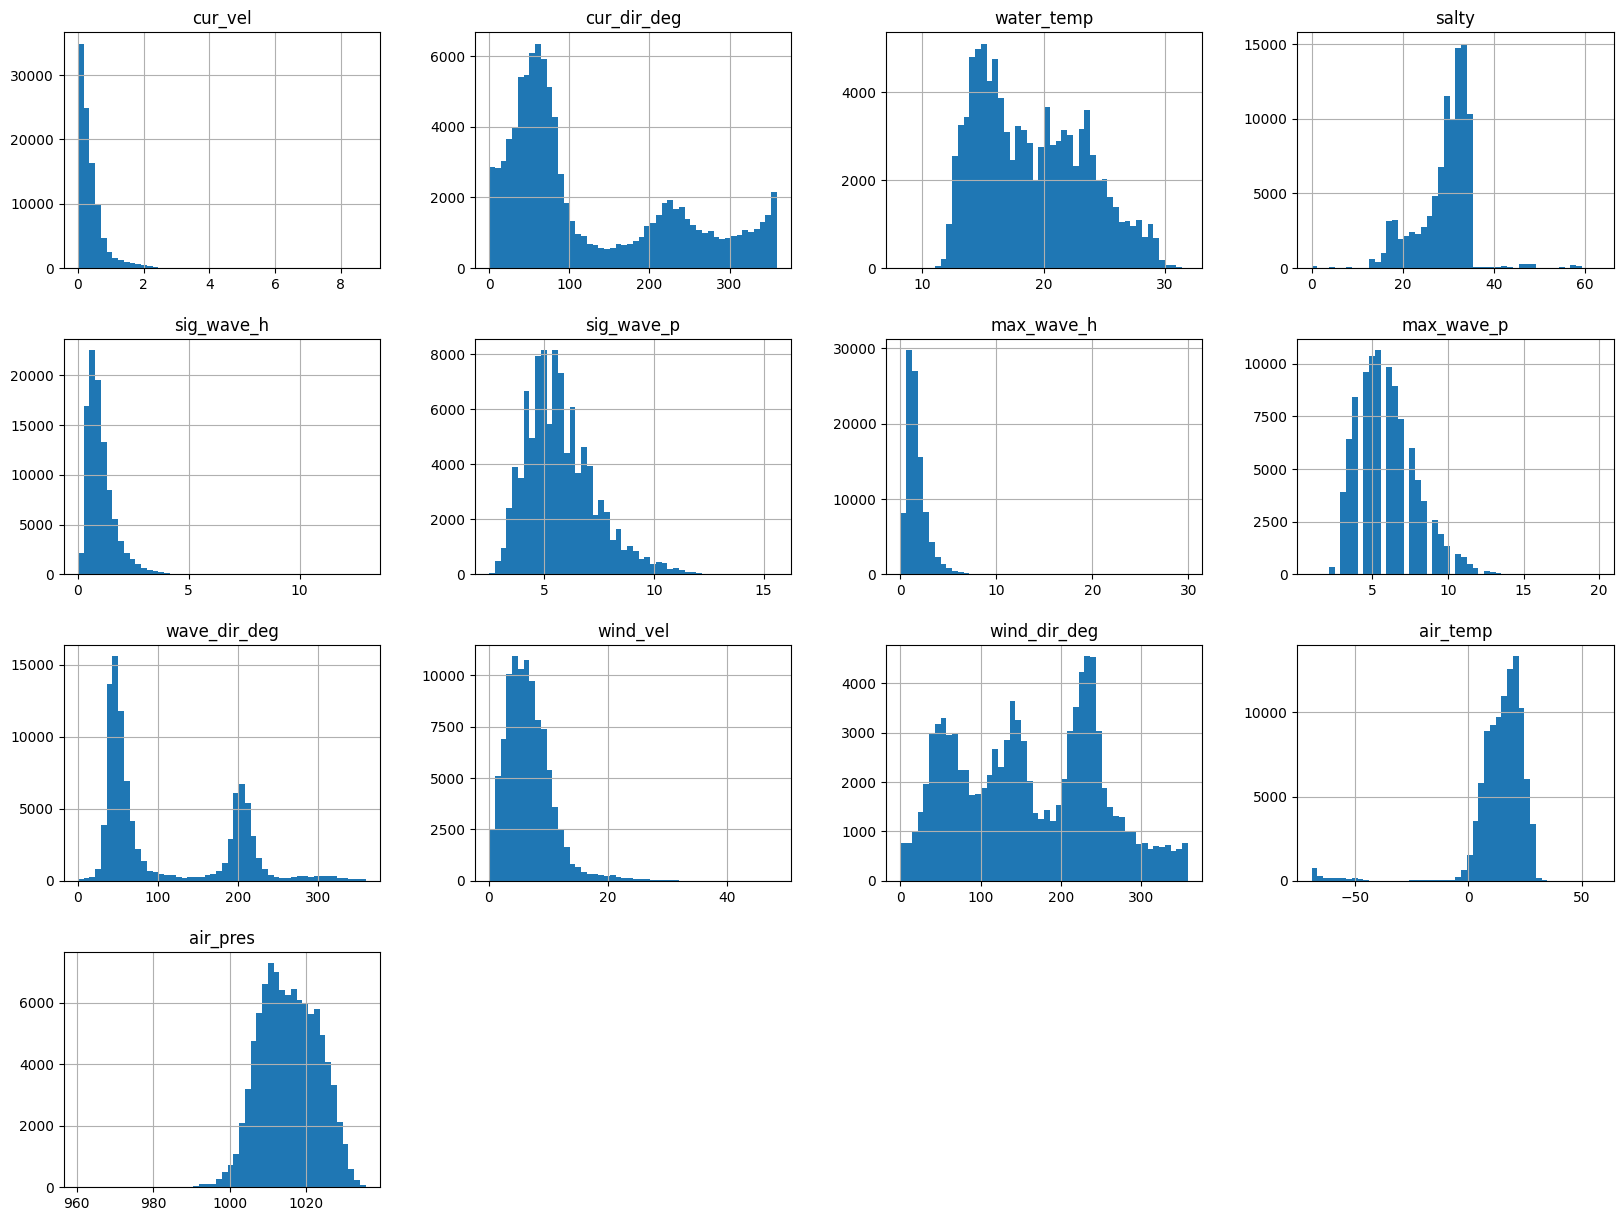

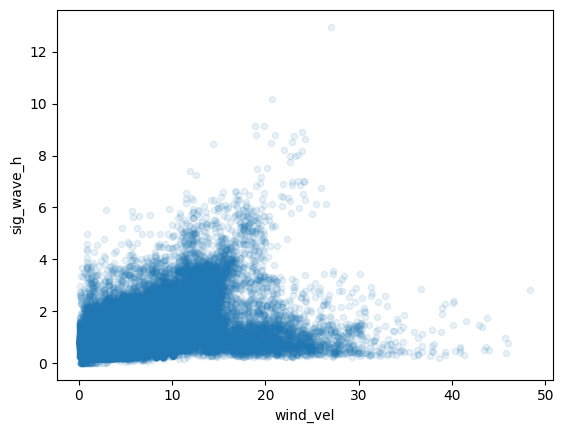

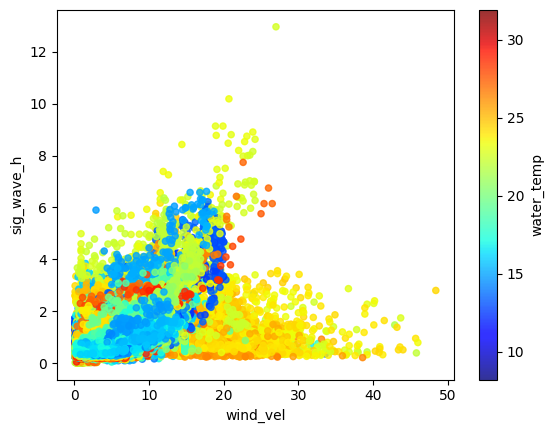

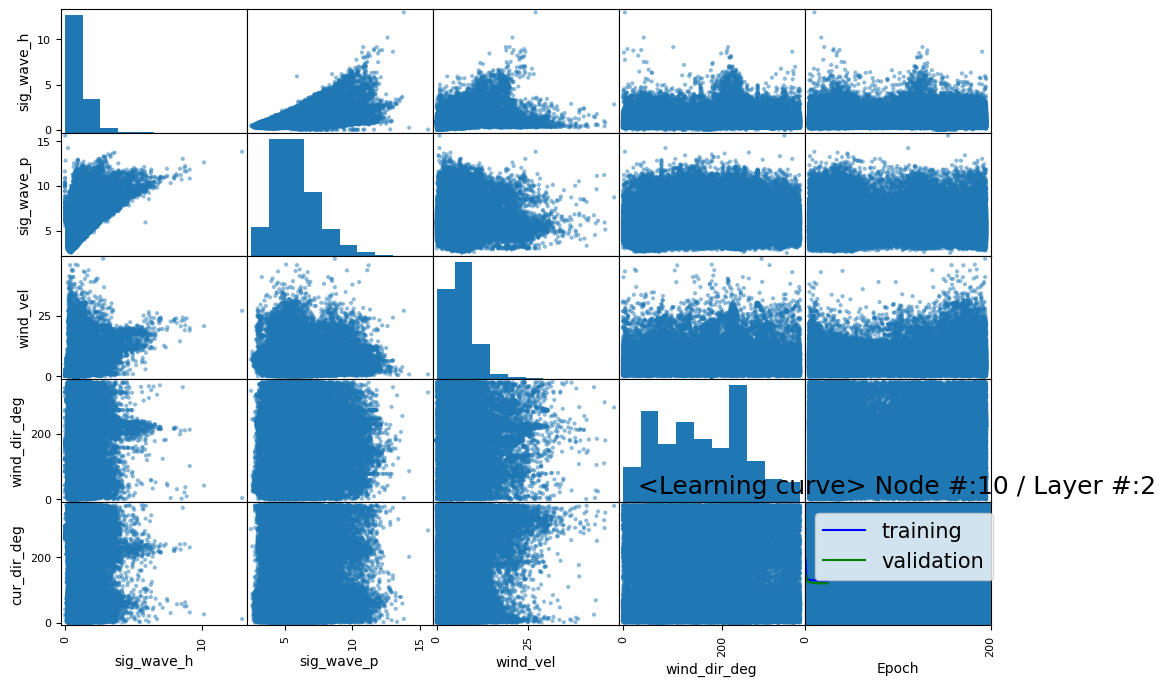

In [47]:
plt.plot(pd.DataFrame(history.history)[['loss']],'b', label='training')
plt.plot(pd.DataFrame(history.history)[['val_loss']],'g', label='validation')
plt.xlabel("Epoch")
plt.ylabel("Loss(MAE)")  # "Loss(MAE)"  logcosh
plt.rcParams['figure.figsize'] = [10, 6]
font = {'weight' : 'normal',
       'size' : 15}
plt.rc('font', **font)
plt.title('<Learning curve> Node #:' + str(node_num)+' / Layer #:'+str(layer_num))
plt.grid(True)
plt.legend()
plt.xlim(-1, 200)
plt.ylim(0, 1)
plt.show()

In [49]:
y_predict = model.predict(X_test)

In [58]:
results = model.evaluate(X_test, y_test, batch_size=128)

155/155 [==============================] - 0s 2ms/step - loss: 0.4011


In [59]:
results

0.40106675028800964

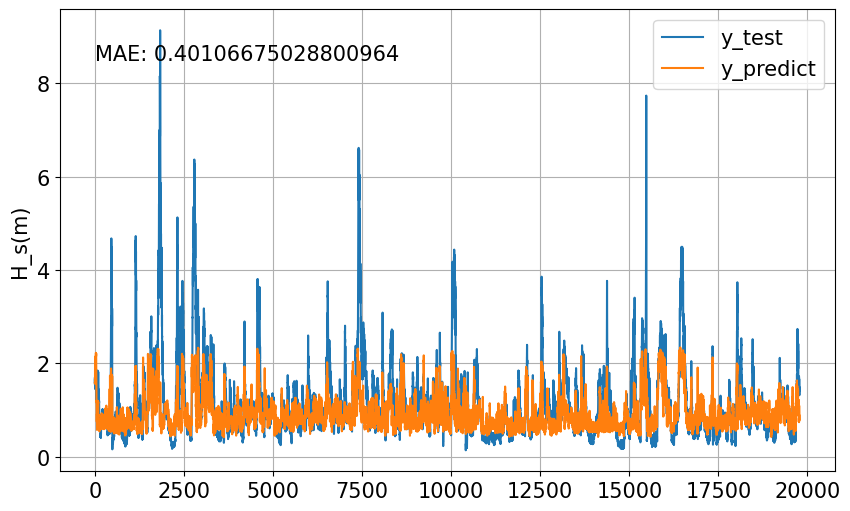

In [62]:
plt.plot(y_test, label='y_test')
plt.plot(y_predict, label='y_predict')
plt.legend()
plt.grid(True)
plt.ylabel('H_s(m)')
plt.text(0, 8.5, "MAE: " + str(results))
plt.show()